In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import torch.nn.functional as F
from PIL import Image

In [3]:
# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [5]:
# Hyperparameters
batch_size = 4  
epochs = 15
learning_rate = 0.0001
train_valid_split = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Data Augmentation and Preprocessing
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(300, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# Dataset Loading
plantdoc_dataset = datasets.ImageFolder(root="Dataset", transform=transform_train)
data_size = len(plantdoc_dataset)
train_size = int(data_size * train_valid_split)
valid_size = int((data_size - train_size) * 0.5)
test_size = data_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    plantdoc_dataset, [train_size, valid_size, test_size]
)
valid_dataset.dataset.transform = transform_valid_test
test_dataset.dataset.transform = transform_valid_test

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)
        return x * self.sigmoid(attention)

In [13]:
# EfficientNetB3 with Spatial Attention
class EfficientNetWithAttention(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetWithAttention, self).__init__()
        weights = EfficientNet_B3_Weights.DEFAULT  
        self.base_model = efficientnet_b3(weights=weights)
        self.spatial_attention = SpatialAttention()
        self.base_model.features[-1].add_module("spatial_attention", self.spatial_attention)
        self.num_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        if not self.training:  # Prevents BatchNorm updates in evaluation mode
            self.base_model.classifier[1].track_running_stats = False
        return self.base_model(x)

model = EfficientNetWithAttention(num_classes=len(plantdoc_dataset.classes)).to(device)

In [15]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # L2 Regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)

In [17]:
# Training and Validation Loop with Early Stopping
def train_and_validate(model, train_loader, valid_loader, epochs, criterion, optimizer, scheduler):
    best_accuracy = 0.0
    patience, patience_counter = 5, 0  # Early Stopping setup
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            if inputs.shape[0] == 1:  # Skip batch with size 1 to avoid BatchNorm error
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                if inputs.shape[0] == 1:  # Skip batch with size 1 in validation
                    continue
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        valid_accuracy = 100 * correct / total
        scheduler.step(valid_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Valid Loss: {valid_loss/len(valid_loader):.4f}, Accuracy: {valid_accuracy:.2f}%")
        
        # Save best model
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), "review_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    
    print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

In [19]:
train_and_validate(model, train_loader, valid_loader, epochs, criterion, optimizer, scheduler)

Epoch [1/15], Train Loss: 2.7927, Valid Loss: 2.2192, Accuracy: 40.95%
Epoch [2/15], Train Loss: 2.1157, Valid Loss: 1.9479, Accuracy: 47.41%
Epoch [3/15], Train Loss: 1.8104, Valid Loss: 1.3900, Accuracy: 58.62%
Epoch [4/15], Train Loss: 1.5368, Valid Loss: 1.1481, Accuracy: 65.52%
Epoch [5/15], Train Loss: 1.2794, Valid Loss: 1.1347, Accuracy: 64.22%
Epoch [6/15], Train Loss: 1.0946, Valid Loss: 1.0824, Accuracy: 65.52%
Epoch [7/15], Train Loss: 0.9569, Valid Loss: 1.0653, Accuracy: 68.97%
Epoch [8/15], Train Loss: 0.7905, Valid Loss: 1.1997, Accuracy: 64.66%
Epoch [9/15], Train Loss: 0.6574, Valid Loss: 1.3074, Accuracy: 66.81%
Epoch [10/15], Train Loss: 0.5285, Valid Loss: 1.3190, Accuracy: 65.52%
Epoch [11/15], Train Loss: 0.4508, Valid Loss: 1.5532, Accuracy: 67.24%
Epoch [12/15], Train Loss: 0.3784, Valid Loss: 1.6325, Accuracy: 65.95%
Early stopping triggered!
Best Validation Accuracy: 68.97%


In [47]:
# Testing the model
def test_model(model, test_loader, model_path="best_model.pth"):
    # Load the state_dict safely
    try:
        state_dict = torch.load(model_path, map_location=device)  # Load the state_dict
        model.load_state_dict(state_dict, strict=False)  # Load with strict=False to handle architecture changes
    except RuntimeError as e:
        print(f"Error loading model state_dict: {e}")
        return
    
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the index of the max logit
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Example usage
test_model(model, test_loader)


C:\Users\iphon\AppData\Local\Temp\ipykernel_3744\753459985.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)  # Lo

Test Accuracy: 72.53%


In [21]:

import matplotlib.pyplot as plt
from PIL import Image
# Define a transformation to convert the image into a tensor and normalize it
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by your model
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example normalization
])

# Function to predict image
def predict_image(image_path, model, class_names, transform=None):
    # Open the image
    image = Image.open(image_path)

    # Apply transformation (like resizing, normalization, etc.)
    if transform:
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension (1 image)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor.to(device))  # Move image to device (CPU/GPU)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]  # Get the predicted class

    return predicted_class, image  # Return predicted class and image



In [23]:
from torchvision import datasets
def predict_severity(image_path):
    from PIL import Image

    global test_transforms  # Ensure it references the global variable
    image = Image.open(image_path)
    image = transform_valid_test(image).unsqueeze(0).to(device)
    severity_levels = ["Mild", "Moderate", "Severe"]

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()

    severity_index = min(class_index // (len(class_names) // len(severity_levels)), len(severity_levels) - 1)


    return severity_levels[severity_index]


In [25]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    
    all_labels = []
    all_preds = []

    # Iterate over the data
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class

            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(preds.cpu().numpy())  # Store predictions

    # Convert lists to tensors for easier handling
    all_labels = torch.tensor(all_labels)
    all_preds = torch.tensor(all_preds)

    # Calculate precision, recall, and f1-score using sklearn
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return precision, recall, f1

# Example usage:
# Assuming you have a DataLoader 'test_loader' and a model 'model' trained on a GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
precision, recall, f1 = evaluate_model(model, test_loader, device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.7298
Recall: 0.7253
F1-Score: 0.7102


C:\Users\iphon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Function to save the entire model
def save_model(model, path="model.pth"):
    torch.save(model, path)
    print(f"Model saved to {path}")

In [35]:
# Function to load the saved model
def load_model(path="model.pth", device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model = torch.load(path, map_location=device)
    model.eval()  # Set model to evaluation mode
    print("Model loaded successfully.")
    return model

In [37]:
save_model(model)

Model saved to model.pth


In [39]:
model = load_model()

Model loaded successfully.


C:\Users\iphon\AppData\Local\Temp\ipykernel_3744\3827921723.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)


Predicted Disease: Apple leaf
Predicted Severity: Mild


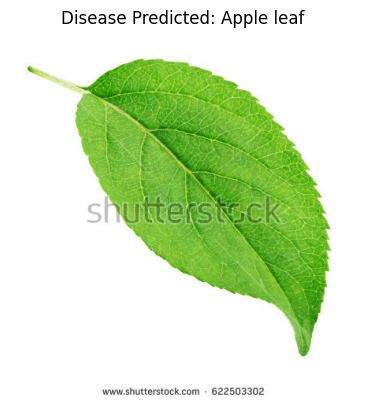

In [111]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Image path and class names
image_path = "test images/Apple leaf (68).jpg"  # Replace with your image path
class_names = plantdoc_dataset.classes  # List of plant disease classes
severity_levels = ["Mild", "Moderate", "Severe"]

# Define a function to predict the severity based on class index
def predict_severity(image_path):
    image = Image.open(image_path)
    image = transform_valid_test(image).unsqueeze(0).to(device)  # Apply your transforms

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()

    # Map the class index to severity level (based on the class distribution)
    severity_index = min(class_index // (len(class_names) // len(severity_levels)), len(severity_levels) - 1)
    return severity_levels[severity_index]

# Define a function to predict the class with unknown category handling
def predict_with_unknown(model, image_path, threshold=0.6):
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to the input size expected by the model
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Ensure the model is in evaluation mode
    model.eval()

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)  # Convert outputs to probabilities
        confidence, predicted_class = torch.max(probs, 1)  # Get the max probability and predicted class
        
    # Check if the confidence is below the threshold
    if confidence.item() < threshold:
        return "Unknown Category (Low Confidence)", None  # Return None for confidence in this case
    else:
        # Return the class name and confidence
        predicted_class_name = class_names[predicted_class.item()]
        return predicted_class_name, confidence.item()

# Predict the class of the input image
predicted_class, confidence = predict_with_unknown(model, image_path, threshold=0.6)

# If the predicted class is "Unknown Category", print it
if predicted_class == "Unknown Category (Low Confidence)":
    print(predicted_class)
else:
    print(f"Predicted Disease: {predicted_class}")

    # Predict the severity based on the class index
    predicted_severity = predict_severity(image_path)
    print(f"Predicted Severity: {predicted_severity}")

    # Display the image and prediction
    image = Image.open(image_path)  # Reopen image for display
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.title(f"Disease Predicted: {predicted_class}")
    plt.show()


Predicted Disease: Corn leaf blight
Predicted Severity: Mild


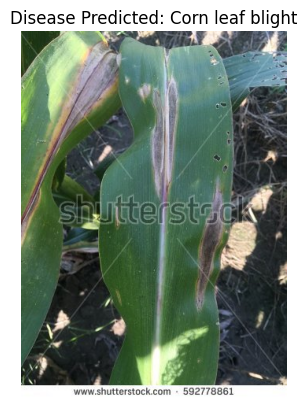

In [119]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Image path and class names
image_path = "test images/Corn leaf blight (174).jpg"  # Replace with your image path
class_names = plantdoc_dataset.classes  # List of plant disease classes
severity_levels = ["Mild", "Moderate", "Severe"]

# Define a function to predict the severity based on class index
def predict_severity(image_path):
    image = Image.open(image_path)
    image = transform_valid_test(image).unsqueeze(0).to(device)  # Apply your transforms

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()

    # Map the class index to severity level (based on the class distribution)
    severity_index = min(class_index // (len(class_names) // len(severity_levels)), len(severity_levels) - 1)
    return severity_levels[severity_index]

# Define a function to predict the class with unknown category handling
def predict_with_unknown(model, image_path, threshold=0.6):
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to the input size expected by the model
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Ensure the model is in evaluation mode
    model.eval()

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)  # Convert outputs to probabilities
        confidence, predicted_class = torch.max(probs, 1)  # Get the max probability and predicted class
        
    # Check if the confidence is below the threshold
    if confidence.item() < threshold:
        return "Unknown Category (Low Confidence)", None  # Return None for confidence in this case
    else:
        # Return the class name and confidence
        predicted_class_name = class_names[predicted_class.item()]
        return predicted_class_name, confidence.item()

# Predict the class of the input image
predicted_class, confidence = predict_with_unknown(model, image_path, threshold=0.6)

# If the predicted class is "Unknown Category", print it
if predicted_class == "Unknown Category (Low Confidence)":
    print(predicted_class)
else:
    print(f"Predicted Disease: {predicted_class}")

    # Predict the severity based on the class index
    predicted_severity = predict_severity(image_path)
    print(f"Predicted Severity: {predicted_severity}")

    # Display the image and prediction
    image = Image.open(image_path)  # Reopen image for display
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.title(f"Disease Predicted: {predicted_class}")
    plt.show()


In [121]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Image path and class names
image_path = "test images/download.jpg"  # Replace with your image path
class_names = plantdoc_dataset.classes  # List of plant disease classes
severity_levels = ["Mild", "Moderate", "Severe"]

# Define a function to predict the severity based on class index
def predict_severity(image_path):
    image = Image.open(image_path)
    image = transform_valid_test(image).unsqueeze(0).to(device)  # Apply your transforms

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()

    # Map the class index to severity level (based on the class distribution)
    severity_index = min(class_index // (len(class_names) // len(severity_levels)), len(severity_levels) - 1)
    return severity_levels[severity_index]

# Define a function to predict the class with unknown category handling
def predict_with_unknown(model, image_path, threshold=0.6):
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to the input size expected by the model
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Ensure the model is in evaluation mode
    model.eval()

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)  # Convert outputs to probabilities
        confidence, predicted_class = torch.max(probs, 1)  # Get the max probability and predicted class
        
    # Check if the confidence is below the threshold
    if confidence.item() < threshold:
        return "Unknown Category (Low Confidence)", None  # Return None for confidence in this case
    else:
        # Return the class name and confidence
        predicted_class_name = class_names[predicted_class.item()]
        return predicted_class_name, confidence.item()

# Predict the class of the input image
predicted_class, confidence = predict_with_unknown(model, image_path, threshold=0.6)

# If the predicted class is "Unknown Category", print it
if predicted_class == "Unknown Category (Low Confidence)":
    print(predicted_class)
else:
    print(f"Predicted Disease: {predicted_class}")

    # Predict the severity based on the class index
    predicted_severity = predict_severity(image_path)
    print(f"Predicted Severity: {predicted_severity}")

    # Display the image and prediction
    image = Image.open(image_path)  # Reopen image for display
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.title(f"Disease Predicted: {predicted_class}")
    plt.show()


Unknown Category (Low Confidence)


Predicted Disease: Tomato leaf yellow virus
Predicted Severity: Severe


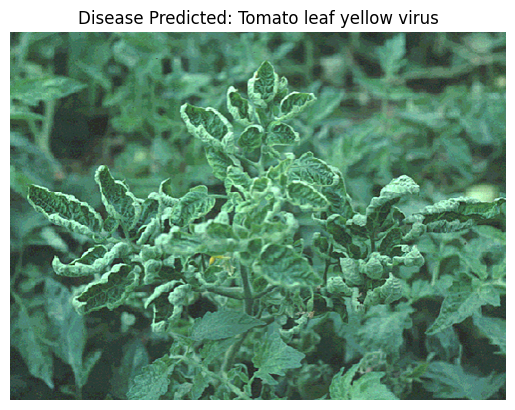

In [123]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Image path and class names
image_path = "test images/Tomato leaf yellow virus (57).jpg"  # Replace with your image path
class_names = plantdoc_dataset.classes  # List of plant disease classes
severity_levels = ["Mild", "Moderate", "Severe"]

# Define a function to predict the severity based on class index
def predict_severity(image_path):
    image = Image.open(image_path)
    image = transform_valid_test(image).unsqueeze(0).to(device)  # Apply your transforms

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_index = predicted.item()

    # Map the class index to severity level (based on the class distribution)
    severity_index = min(class_index // (len(class_names) // len(severity_levels)), len(severity_levels) - 1)
    return severity_levels[severity_index]

# Define a function to predict the class with unknown category handling
def predict_with_unknown(model, image_path, threshold=0.6):
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to the input size expected by the model
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Ensure the model is in evaluation mode
    model.eval()

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)  # Convert outputs to probabilities
        confidence, predicted_class = torch.max(probs, 1)  # Get the max probability and predicted class
        
    # Check if the confidence is below the threshold
    if confidence.item() < threshold:
        return "Unknown Category (Low Confidence)", None  # Return None for confidence in this case
    else:
        # Return the class name and confidence
        predicted_class_name = class_names[predicted_class.item()]
        return predicted_class_name, confidence.item()

# Predict the class of the input image
predicted_class, confidence = predict_with_unknown(model, image_path, threshold=0.6)

# If the predicted class is "Unknown Category", print it
if predicted_class == "Unknown Category (Low Confidence)":
    print(predicted_class)
else:
    print(f"Predicted Disease: {predicted_class}")

    # Predict the severity based on the class index
    predicted_severity = predict_severity(image_path)
    print(f"Predicted Severity: {predicted_severity}")

    # Display the image and prediction
    image = Image.open(image_path)  # Reopen image for display
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.title(f"Disease Predicted: {predicted_class}")
    plt.show()
